## Developing an automated digital reader through ML for quality control of products

In [172]:
# import the necessary packages
import numpy as np
import pandas as pd
import imutils
import cv2

import sys
from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline

from pandas import ExcelWriter
from pandas import ExcelFile

import seaborn as sns

### Read the gel-image data

In [173]:
# read gel-images ...
gels_df = pd.read_csv('processed_gels.csv', encoding='utf-8')
#gels_df.shape

# drop the EARLY part of the waveform
ys= range(0, 250)
ylist= list( map(str, ys) )
gels_df.drop(columns=ylist, inplace=True)

# drop Unnamed: 0 column
gels_df.drop(columns=['Unnamed: 0'], inplace=True)
#gels_df.head(5)

# BELOW is a FIX to avoid dealing with renaming cols.
# temporarily make pandas dataframe a matrix
tmp= gels_df.as_matrix(columns=None)
tmp.shape
# convert matrix-back  to a data-frame
gels_df = pd.DataFrame([])
data = pd.DataFrame(tmp)
gels_df = gels_df.append(data)
gels_df.head(5)

/anaconda3/envs/gelquant/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,-0.105862,-0.105590,-0.104993,-0.106827,-0.108021,-0.106995,-0.108450,-0.108942,-0.109287,-0.108860,...,-0.033031,-0.023423,-0.015248,-0.006953,0.002851,0.006680,0.008641,0.007968,0.007512,0.002170
1,-0.106331,-0.106070,-0.108797,-0.106148,-0.105297,-0.106171,-0.105929,-0.107059,-0.107814,-0.110461,...,0.087279,0.075642,0.062087,0.045206,0.030564,0.015205,0.004341,-0.004882,-0.004405,-0.005831
2,-0.109447,-0.110476,-0.109381,-0.110666,-0.111175,-0.113166,-0.111117,-0.111263,-0.112443,-0.112040,...,0.062422,0.067091,0.076571,0.085279,0.095423,0.105042,0.110485,0.111339,0.106531,0.096575
3,-0.107145,-0.106463,-0.105876,-0.105608,-0.108607,-0.109519,-0.110958,-0.107829,-0.108252,-0.109649,...,-0.021709,-0.007395,0.001012,0.012986,0.018226,0.024746,0.033511,0.041325,0.045792,0.054357
4,-0.072847,-0.070148,-0.070943,-0.071408,-0.069083,-0.071618,-0.068355,-0.067488,-0.064521,-0.061637,...,-0.046266,-0.048433,-0.039686,-0.042258,-0.036259,-0.027008,-0.017318,-0.000535,0.009948,0.023878


In [174]:
#plt.plot(gels_df.iloc[26*5+1,:])

### Read the gel-label data

In [175]:
# read labels ...
labels_df = pd.read_excel('cleaned_data/TeachingGels Score Sheet.xlsx', sheetname='Sheet1')
labels_df.drop(columns=['Unnamed: 4', 'Score Legend', 'Unnamed: 6'], inplace=True)

labels_df['CT_score'].replace('C',0,inplace=True)
labels_df['WZ_score'].replace('C',0,inplace=True)
labels_df['CT_score'].replace('M',10,inplace=True)
labels_df['WZ_score'].replace('M',10,inplace=True)


# max of. the 2 columns
labels_df['liberal_score'] = labels_df[["CT_score", "WZ_score"]].max(axis=1)
# min of. the 2 columns
labels_df['conservative_score'] = labels_df[["CT_score", "WZ_score"]].min(axis=1)


# make it a 3-class classfication problem ...
labels_df['liberal_score'].replace(-1, -2,inplace=True)
labels_df['liberal_score'].replace(1, 2,inplace=True)
labels_df['conservative_score'].replace(-1, -2,inplace=True)
labels_df['conservative_score'].replace(1, 2,inplace=True)

/anaconda3/envs/gelquant/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


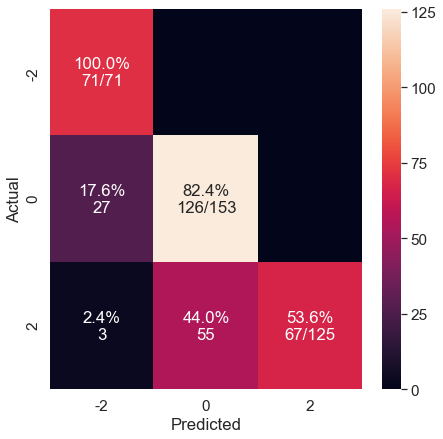

In [186]:
classes =[-2, 0, 2]
cm_analysis(labels_df['liberal_score'], labels_df['conservative_score'], classes, ymap=None, figsize=(7,7))

In [177]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

### Non-AUGMENTED liberal scoring logistic regression model

/anaconda3/envs/gelquant/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/envs/gelquant/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


model train accuracy: 0.7168458781362007
model cross vaildation accuracy:0.603578796682245


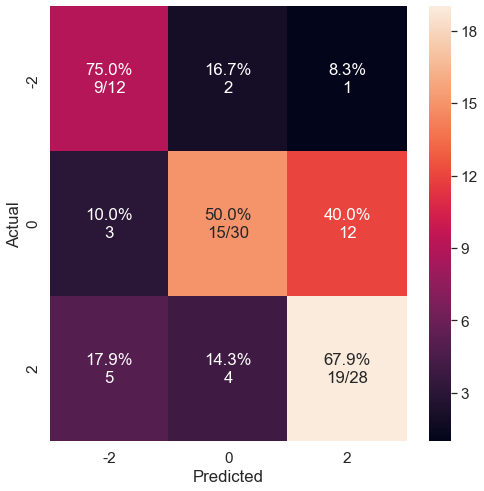

model test accuracy: 0.603578796682245


In [178]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

quality= pd.concat([labels_df, gels_df], axis=1)

# drop "M" rows
quality.drop(quality[quality.liberal_score== 10].index, inplace=True)

# TESTING a random pattern  ...
#random_df = pd.DataFrame(np.random.randint(0,100,size=(364, 425)).astype(float))
#labels_df = pd.DataFrame(np.random.randint(-2, 3, size=(364, 1)), columns=['conservative_score'])
#quality= pd.concat([labels_df, random_df], axis=1)

quality.drop(columns=['Gel', 'Lane', 'CT_score', 'WZ_score', 'conservative_score'], axis=1, inplace=True)
quality['Target'] = quality['liberal_score']
y = quality.Target.values

feature_cols = [i for i in list(quality.columns) if i not in ['Target', 'liberal_score', 'Unnamed: 0']]
X = quality.ix[:, feature_cols].as_matrix()

#X = quality.ix[:, feature_cols].as_matrix()

# Illustrated here for manual splitting of training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Standarize features
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)


# define method
logreg= LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='newton-cg')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)

# Use score method to get accuracy of model
score = logreg.score(X_train, y_train)
print('model train accuracy:', score)

# Use cross_val_score to automatically split, fit, and score.
scores = cross_val_score(logreg, X_train, y_train, cv=10)
#print(scores)
print('model cross vaildation accuracy:{}'.format(scores.mean()))


#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size

classes =[-2, 0, 2]
y_pred = logreg.predict(X_test)
cm_analysis(y_test, y_pred, classes, ymap=None, figsize=(8,8))

# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print('model test accuracy: {}'.format(scores.mean()))

### Data augmention

### Read the gel-label data

In [179]:
# read labels ...
labels_df = pd.read_excel('cleaned_data/TeachingGels Score Sheet.xlsx', sheetname='Sheet1')
labels_df.drop(columns=['Unnamed: 4', 'Score Legend', 'Unnamed: 6'], inplace=True)


labels_df['CT_score'].replace('C',0,inplace=True)
labels_df['WZ_score'].replace('C',0,inplace=True)
labels_df['CT_score'].replace('M',10,inplace=True)
labels_df['WZ_score'].replace('M',10,inplace=True)


# max of. the 2 columns
labels_df['liberal_score'] = labels_df[["CT_score", "WZ_score"]].max(axis=1)

# min of. the 2 columns
labels_df['conservative_score'] = labels_df[["CT_score", "WZ_score"]].min(axis=1)


# make it a 3-class classfication problem ...
labels_df['liberal_score'].replace(-1, -2,inplace=True)
labels_df['conservative_score'].replace(-1, -2,inplace=True)
labels_df['liberal_score'].replace(1, 2,inplace=True)
labels_df['conservative_score'].replace(1, 2,inplace=True)

/anaconda3/envs/gelquant/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [180]:
from statsmodels import api as sm

def nextpow2(i):
    '''
    Find the next power 2 number for FFT
    '''
    
    n = 1
    while n < i: n *= 2
    return n

def shift_signal_in_frequency_domain(datin, shift):
    '''
    This is function to shift a signal in frequency domain. 
    The idea is in the frequency domain, 
    we just multiply the signal with the phase shift. 
    '''
    Nin = len(datin) 
    
    # get the next power 2 number for fft
    N = nextpow2(Nin +np.max(np.abs(shift)))
    
    # do the fft
    fdatin = np.fft.fft(datin, N)
    
    # get the phase shift for the signal, shift here is D in the above explaination
    ik = np.array([2j*np.pi*k for k in range(0, N)]) / N 
    fshift = np.exp(-ik*shift)
        
    # multiple the signal with the shift and transform it back to time domain
    datout = np.real(np.fft.ifft(fshift * fdatin))
    
    # only get the data have the same length as the input signal
    datout = datout[0:Nin]
    
    return datout


# temporarily make pandas dataframe a matrix (to append lag signals)
tmp= np.empty((0, 177), float)
# tmp.shape

strt_lag= -14
end_lag= 14
inc_lag= 2

# augment shifted signals
for index, row in gels_df.iterrows():
    for lag in range(strt_lag, end_lag, inc_lag):    
        y_shift = shift_signal_in_frequency_domain(row, lag)    
        tmp = np.r_[tmp, y_shift.reshape((1, 177))]

# tmp.shape
# make the data-augmented matrix to a data-frame
gels_aug_df= pd.DataFrame(tmp)
#gels_aug_df

# augment corresponding labels into the matrix
labels_aug_df= pd.DataFrame()
for index, row in labels_df.iterrows():
    for lag in range(strt_lag, end_lag, inc_lag):    
        labels_aug_df= labels_aug_df.append(row)
        
#labels_aug_df



### RESET Indices

In [181]:
gels_aug_df.reset_index(drop=True, inplace=True)
labels_aug_df.reset_index(drop=True, inplace=True)

### Build an AUGMENTED logistic regression model

/anaconda3/envs/gelquant/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/envs/gelquant/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


model train accuracy: 0.6642784032753326
model cross vaildation accuracy:0.641748896883168


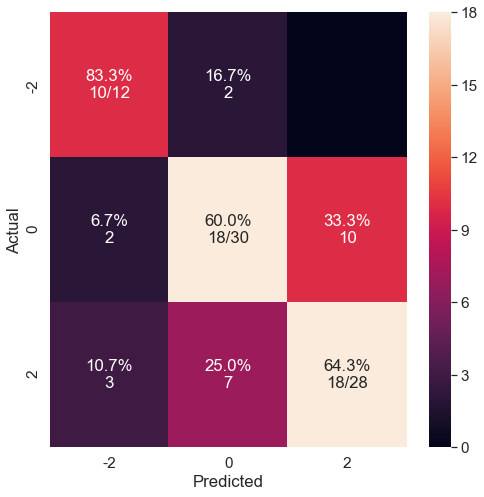

model test accuracy: 0.6571428571428571


In [182]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

quality_aug= pd.concat([labels_aug_df, gels_aug_df], axis=1)

# drop "M" rows
quality_aug.drop(quality_aug[quality_aug.liberal_score== 10].index, inplace=True)


quality_aug.drop(columns=['Gel', 'Lane', 'CT_score', 'WZ_score', 'conservative_score'], axis=1, inplace=True)
quality_aug['Target'] = quality_aug['liberal_score']
y = quality_aug.Target.values

feature_cols = [i for i in list(quality.columns) if i not in ['Target', 'liberal_score', 'Unnamed: 0']]
X = quality_aug.ix[:, feature_cols].as_matrix()


# Illustrated here for manual splitting of training and testing data.
X_train, X_test_aug, y_train, y_test_aug = train_test_split(X, y, test_size=0.2, random_state=0)


# Standarize features
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test_aug= scaler.transform(X_test_aug)


# define method
logreg= LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='newton-cg')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)

# Use score method to get accuracy of model
score = logreg.score(X_train, y_train)
print('model train accuracy:', score)

# Use cross_val_score to automatically split, fit, and score.
scores = cross_val_score(logreg, X_train, y_train, cv=10)
#print(scores)
print('model cross vaildation accuracy:{}'.format(scores.mean()))


#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size

classes =[-2, 0, 2]
y_pred = logreg.predict(X_test)
cm_analysis(y_test, y_pred, classes, ymap=None, figsize=(8,8))

# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print('model test accuracy: {}'.format(score))

### Train a Random forest classifier

/anaconda3/envs/gelquant/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/anaconda3/envs/gelquant/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


model train accuracy: 0.9994882292732856
model cross vaildation accuracy:0.8377886572689277


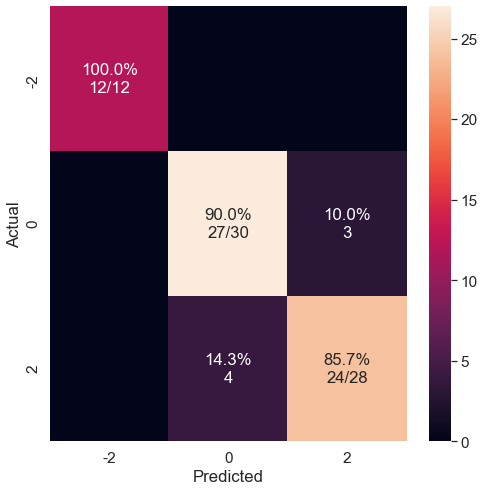

model test accuracy: 0.9


In [183]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

quality_aug= pd.concat([labels_aug_df, gels_aug_df], axis=1)

# drop "M" rows
quality_aug.drop(quality_aug[quality_aug.liberal_score== 10].index, inplace=True)


quality_aug.drop(columns=['Gel', 'Lane', 'CT_score', 'WZ_score', 'conservative_score'], axis=1, inplace=True)
quality_aug['Target'] = quality_aug['liberal_score']
y = quality_aug.Target.values

feature_cols = [i for i in list(quality.columns) if i not in ['Target', 'liberal_score', 'Unnamed: 0']]
X = quality_aug.ix[:, feature_cols].as_matrix()


# Illustrated here for manual splitting of training and testing data.
X_train, X_test_aug, y_train, y_test_aug = train_test_split(X, y, test_size=0.2, random_state=0)


# Standarize features
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
#X_test_aug= scaler.transform(X_test_aug)


# define method
rf_clf = RandomForestClassifier(n_jobs=2, n_estimators=40, random_state=0)

# Create an instance of Logistic Regression Classifier and fit the data.
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)

# Use score method to get accuracy of model
score = rf_clf.score(X_train, y_train)
print('model train accuracy:', score)

# Use cross_val_score to automatically split, fit, and score.
scores = cross_val_score(rf_clf, X_train, y_train, cv=10)
#print(scores)
print('model cross vaildation accuracy:{}'.format(scores.mean()))


#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size

classes =[-2, 0, 2]
y_pred = rf_clf.predict(X_test)
cm_analysis(y_test, y_pred, classes, ymap=None, figsize=(8,8))

# Use score method to get accuracy of model
score = rf_clf.score(X_test, y_test)
print('model test accuracy: {}'.format(score))

### Save the model

In [184]:
import pickle
f1='random_forest_model.pkl'
f2='scaler.pkl'

#pickle.dump(rf_clf, open(f1, 'wb'))
#pickle.dump(scaler, open(f2, 'wb'))

load_rf_model =pickle.load(open(f1, 'rb'))
#load_lr_model.coef_

y_load_predit= load_rf_model.predict(X_test)
#y_load_predit